In [ ]:
!pip install --upgrade opencv-contrib-python

In [ ]:
!pip install opencv-contrib-python==4.7.0.72

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.11.0.86
    Uninstalling opencv-contrib-python-4.11.0.86:
      Successfully uninstalled opencv-contrib-python-4.11.0.86


In [ ]:
!pip install numpy==1.24.4 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is 

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import cv2
from sklearn.cluster import DBSCAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


SIFT and FREAK function to detect keypoints, match descriptors, select bounding box and generate binary mask.


In [ ]:
def sift_freak(gray_image, forged_image):
    # === Feature Detection and Description ===

    # -- SIFT feature detection and descriptor extraction
    sift = cv2.SIFT_create(contrastThreshold=0.01, edgeThreshold=5, sigma=0.7)
    kp_sift, des_sift = sift.detectAndCompute(gray_image, None)

    # -- STAR keypoint detector + FREAK descriptor extractor
    star = cv2.xfeatures2d.StarDetector_create()
    freak = cv2.xfeatures2d.FREAK_create()
    kp_freak = star.detect(gray_image, None)
    kp_freak, des_freak = freak.compute(gray_image, kp_freak)

    # === Feature Matching ===

    # -- Match SIFT descriptors using L2 norm
    bf_sift = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches_sift = bf_sift.knnMatch(des_sift, des_sift, k=2)

    # -- Filter SIFT matches using Lowe's ratio test
    good_sift = []
    for m, n in matches_sift:
        if m.distance < 0.95 * n.distance and m.queryIdx != m.trainIdx:
            good_sift.append(m)

    # -- Fallback if not enough good SIFT matches
    if len(good_sift) < 10:
        matches = bf_sift.match(des_sift, des_sift)
        good_sift = [m for m in matches if m.queryIdx != m.trainIdx]
        good_sift = sorted(good_sift, key=lambda x: x.distance)

    # -- Match FREAK descriptors using Hamming distance
    bf_freak = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches_freak = bf_freak.knnMatch(des_freak, des_freak, k=2)

    # -- Filter FREAK matches with ratio test
    good_freak = []
    for pair in matches_freak:
        if len(pair) == 2:
            m, n = pair
            if m.distance < 0.8 * n.distance and m.queryIdx != m.trainIdx:
                good_freak.append(m)

    # === Combine Keypoints and Matches ===

    # -- Merge SIFT and FREAK keypoints
    all_keypoints = kp_sift + kp_freak

    # -- Adjust indices for FREAK matches (to reflect position in combined keypoints)
    offset = len(kp_sift)
    adjusted_freak = [
        cv2.DMatch(_queryIdx=m.queryIdx + offset, _trainIdx=m.trainIdx + offset, _distance=m.distance)
        for m in good_freak
    ]

    # -- Combine both SIFT and adjusted FREAK matches
    all_matches = good_sift + adjusted_freak

    # -- Extract matched point coordinates from keypoints
    query_pts_2 = np.array([all_keypoints[m.queryIdx].pt for m in all_matches], dtype=np.int32)
    train_pts_2 = np.array([all_keypoints[m.trainIdx].pt for m in all_matches], dtype=np.int32)

    # === Create Binary Mask of Forged Regions ===

    # Step 1: Initialize an empty binary mask (black image)
    binary_filled_mask = np.zeros(forged_image.shape[:2], dtype=np.uint8)

    # Step 2: Cluster and fill regions of copied areas (from query points)
    if len(query_pts_2) >= 2:
        db_query = DBSCAN(eps=30, min_samples=3).fit(query_pts_2)
        query_labels = db_query.labels_
        for label in set(query_labels):
            if label == -1:
                continue  # Ignore noise points
            cluster_points = np.int32(query_pts_2[query_labels == label])
            x, y, w, h = cv2.boundingRect(cluster_points)
            cv2.rectangle(binary_filled_mask, (x, y), (x + w, y + h), 255, thickness=cv2.FILLED)

    # Step 3: Cluster and fill regions of pasted areas (from train points)
    if len(train_pts_2) >= 2:
        db_train = DBSCAN(eps=30, min_samples=3).fit(train_pts_2)
        train_labels = db_train.labels_
        for label in set(train_labels):
            if label == -1:
                continue  # Ignore noise points
            cluster_points = np.int32(train_pts_2[train_labels == label])
            x, y, w, h = cv2.boundingRect(cluster_points)
            cv2.rectangle(binary_filled_mask, (x, y), (x + w, y + h), 255, thickness=cv2.FILLED)

    # Return the final binary mask highlighting the detected forged regions
    return binary_filled_mask


In [ ]:
# Directory containing the images
images_dir = "/content/drive/MyDrive/CoMoFoD_small_v2"

# Output directory where binary masks will be saved
images_out_dir = "/content/drive/MyDrive/CoMoFoD_small_v2/binary_mask"
os.makedirs(images_out_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Loop through a range of image indices
for start_index in range(1, 201):
    # Format index to match file naming convention (e.g., 100 -> "100")
    file_id = f"{start_index:03d}"
    forged_path = f"{images_dir}/{file_id}_F.png"  # Path to forged image

    # Load the forged image
    forged = cv2.imread(forged_path)
    if forged is None:
        print(f"Error loading image: {forged_path}")
        continue  # Skip to next iteration if image not found

    # Convert forged image to grayscale
    forged_gray = cv2.cvtColor(forged, cv2.COLOR_BGR2GRAY)

    # Resize the forged image and grayscale version to 512x512
    forged = cv2.resize(forged, (512, 512))
    forged_gray = cv2.resize(forged_gray, (512, 512))

    # Apply Laplacian filter to enhance edges
    lap = cv2.Laplacian(forged_gray, cv2.CV_64F, ksize=3)
    lap = cv2.convertScaleAbs(lap)

    # Sharpen the grayscale image using the Laplacian result
    sharpened = cv2.addWeighted(forged_gray, 1.6, lap, -0.6, 0)

    # Improve contrast/brightness
    enhanced = cv2.convertScaleAbs(sharpened, alpha=1, beta=30)

    # Apply histogram equalization to normalize brightness and contrast
    C_combined_image = cv2.equalizeHist(enhanced)

    # Detect forgery using SIFT+FREAK pipeline (assumed custom function)
    binary_filled_mask = sift_freak(C_combined_image, forged)

    # If no forgery detected (all zeros), print message and skip saving
    if np.sum(binary_filled_mask) == 0:
        print(f"{file_id}: No forgery detected.")
        continue

    # Convert binary mask (0/1) to uint8 format (0/255) for saving
    binary_mask_uint8 = (binary_filled_mask * 255).astype(np.uint8)

    # Construct path and save the binary mask image
    mask_path = os.path.join(images_out_dir, f"{file_id}_bin.png")
    cv2.imwrite(mask_path, binary_mask_uint8)
    print(f"Saved binary mask: {mask_path}")


100: No forgery detected.
101: No forgery detected.
102: No forgery detected.
103: No forgery detected.
104: No forgery detected.
105: No forgery detected.
106: No forgery detected.
107: No forgery detected.
108: No forgery detected.
109: No forgery detected.
110: No forgery detected.
Saved binary mask: /content/drive/MyDrive/CoMoFoD_small_v2/binary_mask/111_bin.png
112: No forgery detected.
113: No forgery detected.
114: No forgery detected.
115: No forgery detected.
116: No forgery detected.
117: No forgery detected.
118: No forgery detected.
119: No forgery detected.
120: No forgery detected.
121: No forgery detected.
122: No forgery detected.
123: No forgery detected.
124: No forgery detected.
125: No forgery detected.
126: No forgery detected.
127: No forgery detected.
128: No forgery detected.
129: No forgery detected.
130: No forgery detected.
131: No forgery detected.
132: No forgery detected.
133: No forgery detected.
134: No forgery detected.
135: No forgery detected.
136: No

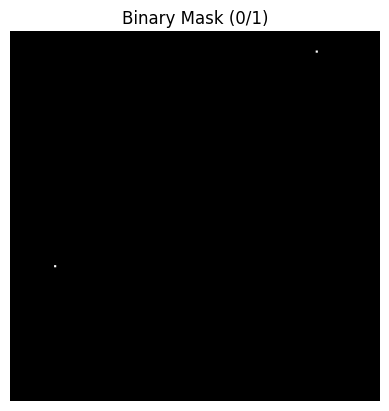

In [ ]:
plt.imshow(binary_mask_uint8, cmap='gray')
plt.title("Binary Mask (0/1)")
plt.axis('off')
plt.show()


Load the binary mask

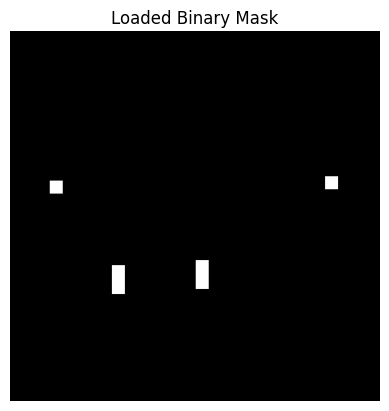

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the saved binary mask
mask_path = "/content/drive/MyDrive/CoMoFoD_small_v2/binary_mask/039_bin.png"
loaded_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Optional: Convert to binary (0 or 1) if needed for logic
binary_mask = (loaded_mask > 128).astype(np.uint8)

# Visualize
plt.imshow(loaded_mask, cmap='gray')
plt.title("Loaded Binary Mask")
plt.axis('off')
plt.show()